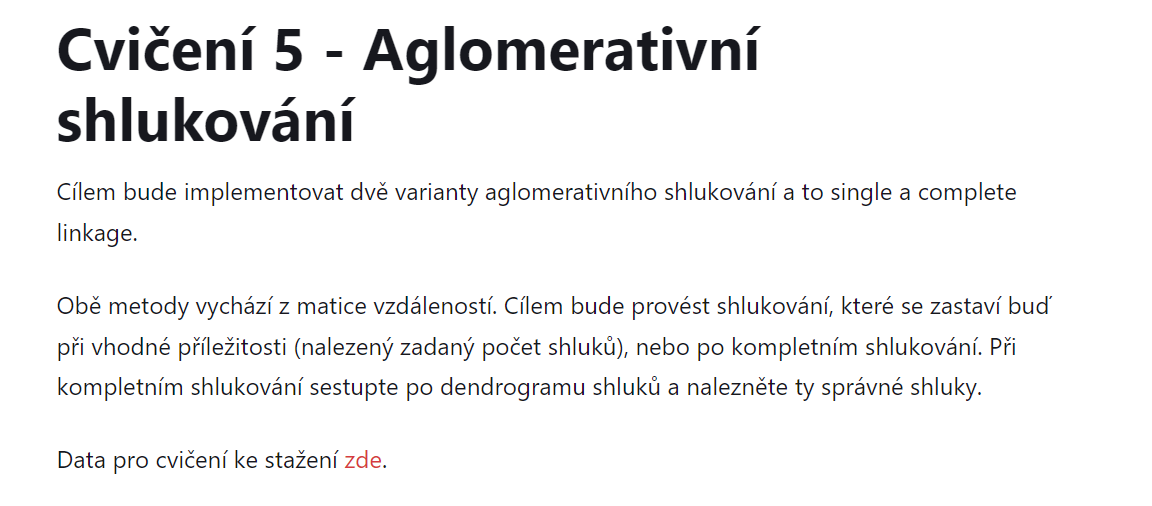

In [1]:
import pandas as pd
from enum import Enum
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import random

## Poznámky

- Dendogram
- Vizualizace výsledků
- Výběr počet shluků nebo ideální řez

## Konfigurace notebooku

In [2]:
verbose = False
K = 3

#complete | single
LINKAGE = 'single'

## Úkol

In [3]:
class Paths(Enum):
    annulus = 'annulus.csv'
    boxes = 'boxes.csv'
    clusters3 = 'clusters3.csv'
    clusters5 = 'clusters5.csv'
    clusters5n = 'clusters5n.csv'
    densegrid = 'densegrid.csv'

In [4]:
path = f'./data/{Paths.clusters3.value}'

In [9]:
data = pd.read_csv(path, sep=';', header=None)

In [10]:
data = data;
data.shape

(300, 2)

In [7]:
data = data.iloc[np.random.randint(data.shape[0], size=int(data.shape[0] * 0.1)), :]

In [11]:
data.shape

(300, 2)

In [12]:
def calc_distance(a, b):
    return np.linalg.norm(a-b)

In [13]:
def calc_distance_man(a, b):
    return np.sum(np.absolute(a-b))

In [14]:
def create_distance_matrix(data, distance_callback):
    size = data.shape[0]
    M = np.zeros(shape=(size, size))
    for y in range(size):
        current_y = data.iloc[y]
        for x in range(y, size):
            current_x = data.iloc[x]
            distance = distance_callback(current_y, current_x)            
            M[y][x] = distance
            M[x][y] = distance
    return M

In [15]:
M = create_distance_matrix(data, calc_distance)

In [16]:
M

array([[ 0.        ,  1.27626915,  0.84859119, ...,  9.15609135,
         9.93691072,  9.22820479],
       [ 1.27626915,  0.        ,  0.45291392, ..., 10.25086103,
        11.00559463, 10.20192182],
       [ 0.84859119,  0.45291392,  0.        , ...,  9.81106578,
        10.57039706,  9.78461959],
       ...,
       [ 9.15609135, 10.25086103,  9.81106578, ...,  0.        ,
         0.86056813,  1.57964383],
       [ 9.93691072, 11.00559463, 10.57039706, ...,  0.86056813,
         0.        ,  1.46461372],
       [ 9.22820479, 10.20192182,  9.78461959, ...,  1.57964383,
         1.46461372,  0.        ]])

## Single

In [17]:
def single_linkage_concat(tuples, matrix):
    #Be careful cause similarity is "opposite" to distance.
    #We look for maximum similar (the nearest) individuals!
    res = 0
    lengths = [matrix[y][x] for y, x in tuples]
    res = np.min(lengths)
    if verbose:
        print('tuple', tuples)
        print('matrix\n', pd.DataFrame(matrix))
        print('lengths', lengths);
        print('res', res)
        print('========================')
        print('\n')
    return res

## Complete

In [18]:
def complete_linkage_concat(tuples, matrix):
    #Be careful cause similarity is "opposite" to distance.
    #We look for minimum similar (furthest individuals) individuals!
    res = 0
    lengths = [matrix[y, x] for y, x in tuples]
    res = np.max(lengths)
    return res

In [19]:
def rebuild(cluster_names, matrix, selected_pair, concatation_func):
    new_cluster_names = []
    for name in cluster_names:
        ignore = set(cluster_names[selected_pair[1]])
        A = set(cluster_names[selected_pair[0]])
        target_name = set(name)
        if ignore.issubset(target_name):
            continue
        if A == target_name:
            merged = name + cluster_names[selected_pair[1]]
            new_cluster_names.append(merged)
        else:
            new_cluster_names.append(name)
            

    new_size = len(new_cluster_names)
    new_matrix = np.zeros(shape=(new_size, new_size))
    
    if verbose:
        print(new_cluster_names)

    for y in range(new_size):
        from_cluster = new_cluster_names[y]        
        for x in range(new_size):
            if x == y:
                new_matrix[y][x] = 0
            to_cluster = new_cluster_names[x]
            new_matrix[y][x] = concatation_func(list(product(from_cluster, to_cluster)), matrix)
    return new_matrix, new_cluster_names

In [21]:
def get_linkage(linkage=LINKAGE):
    print(f'current linkage -> {LINKAGE}')
    return single_linkage_concat if LINKAGE == 'single' else complete_linkage_concat 

In [22]:
def hierarchical_clustering(input_matrix, concatation_func = get_linkage(), k = K, distance_break = None):
    matrix = input_matrix.copy()
    cluster_names = [[i] for i in range(len(matrix))]    
    snapshots = {}

    while len(cluster_names) > 1:
        distance_matrix_len = len(matrix)
        distance  = None
        selected_pair = None

        if verbose:
            print(pd.DataFrame(matrix))

        for i in range(distance_matrix_len):
            for j in range(i+1, distance_matrix_len):
                if distance is None:
                    distance = matrix[i][j]
                    selected_pair = (i, j)      
                ## Carefuly! We look for the most closes
                if matrix[i][j] < distance:
                    distance = matrix[i][j]
                    selected_pair = (i, j)
                    
        if verbose:
            print(pd.DataFrame(matrix))
            print('Distance', distance)
            print('Selected pair', selected_pair)
            print(f'GEN {len(cluster_names)}')
        snapshots[len(snapshots.keys())] = (matrix, cluster_names) #
        matrix, cluster_names = rebuild(cluster_names, input_matrix, selected_pair, concatation_func)

    key = len(snapshots.keys()) - (K - 1)
    selected_snapshot = snapshots[key] 
    return selected_snapshot, snapshots

current linkage -> single


In [23]:
selected, all_s = hierarchical_clustering(M, single_linkage_concat, K);

In [24]:
def create_dics(array):
    clusterIndex2cluster =  {i:a for i, a in enumerate(array)}
    value2clusterIndex = {v:k for k, val in clusterIndex2cluster.items() for v in val} 
    return clusterIndex2cluster, value2clusterIndex

In [25]:
def plot(all_s, K, data):
    matrix, clusters = all_s[len(all_s.keys()) - K + 1]  
    one, two = create_dics(clusters)
    df = pd.DataFrame()
    x = data.values[:, 0]
    y = data.values[:, 1]
    df['X'] = x
    df['Y'] = y
    df['cluster'] = [two[i] for i in range(len(two.keys()))] 
    fig = plt.figure(figsize=((9,6)))
    scatter_plot = sns.scatterplot(data=df, x='X', y='Y', hue='cluster', palette='deep')
    return scatter_plot

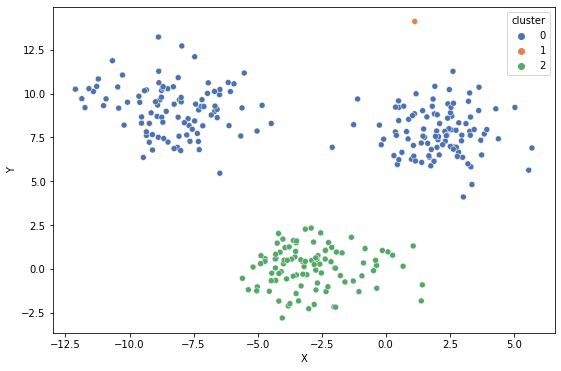

In [26]:
scatter_plot = plot(all_s, 3, data)

In [48]:
fig = scatter_plot.get_figure()
fig.savefig('save/test.png') 

In [68]:
def run_for_ds(ds, sample, Ks):
    load_path = f'./data/{ds.value}'
    loaded_data = pd.read_csv(load_path, sep=';', header=None)
    print(loaded_data.shape)
    loaded_data = loaded_data.iloc[np.random.randint(loaded_data.shape[0], size=int(loaded_data.shape[0] * sample)), :]
    print(loaded_data.shape)
    
    
    for i, distance_method in enumerate([calc_distance, calc_distance_man]):
        name = 'euclid' if i == 0 else 'man'
        M = create_distance_matrix(loaded_data, distance_method)
        for linkage_type in ['single', 'complete']:
            print(linkage_type)
            linkage = get_linkage(linkage_type)
            _, all_s = hierarchical_clustering(M, linkage, 2)
            for K in Ks:
                print(f'\t {K}')
                scatter_plot = plot(all_s, K, loaded_data)
                fig = scatter_plot.get_figure()
                fig.savefig(f'save/{ds.value}_Method-{name}_K-{K}_Linkage-{linkage_type}.png') 
            

(300, 2)
(300, 2)
single
	 2
	 3
	 4
complete
	 2
	 3
	 4
single
	 2
	 3
	 4
complete
	 2
	 3
	 4


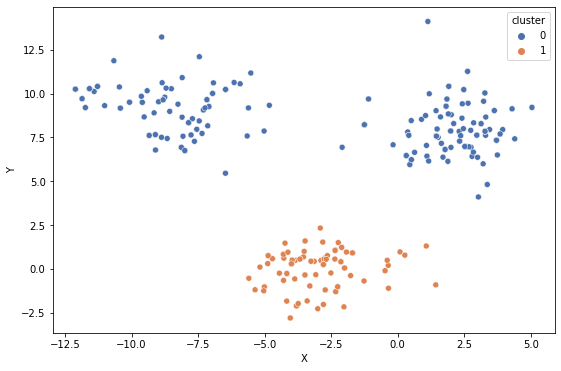

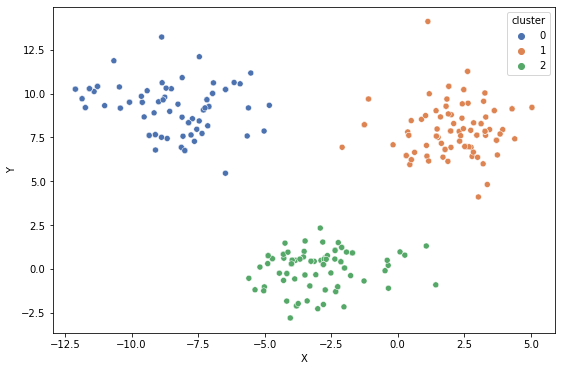

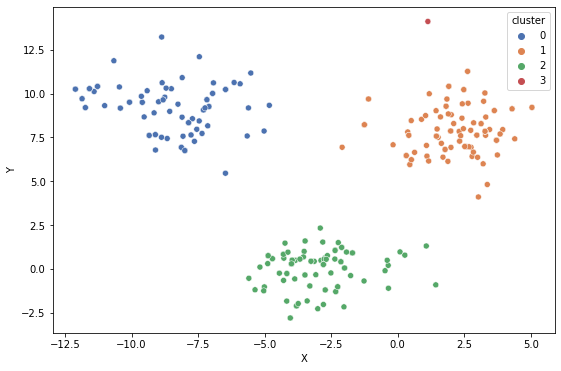

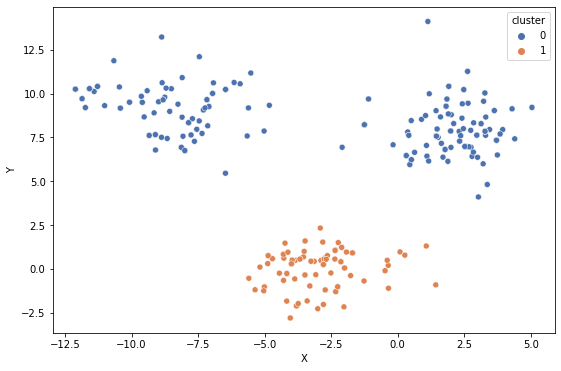

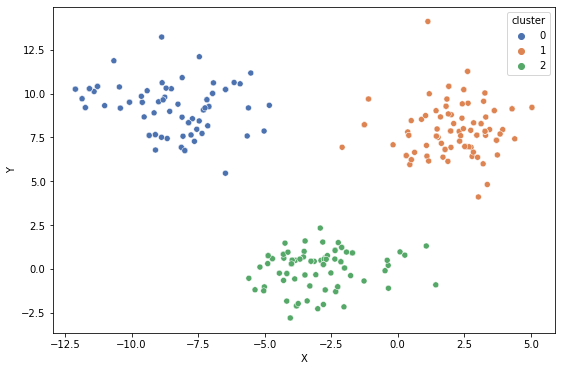

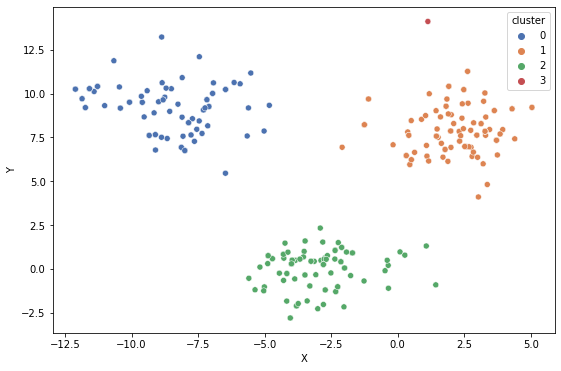

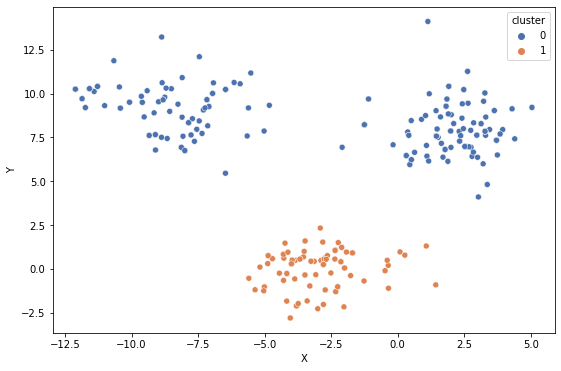

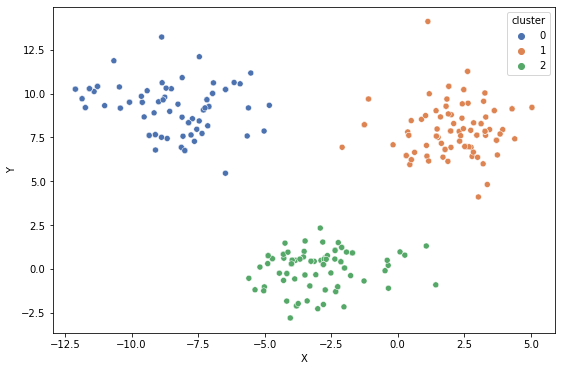

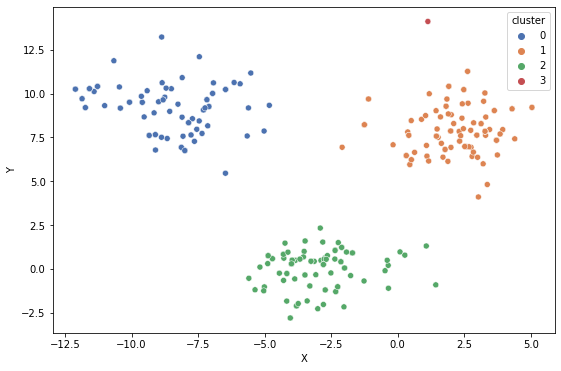

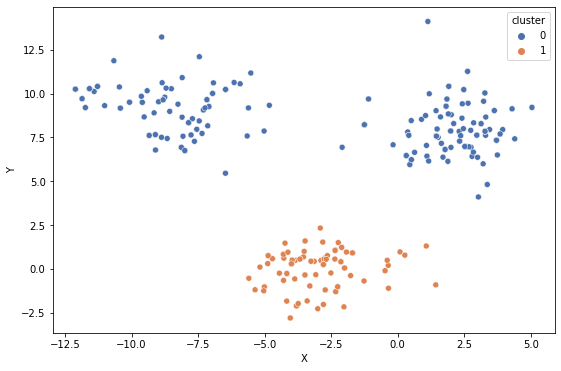

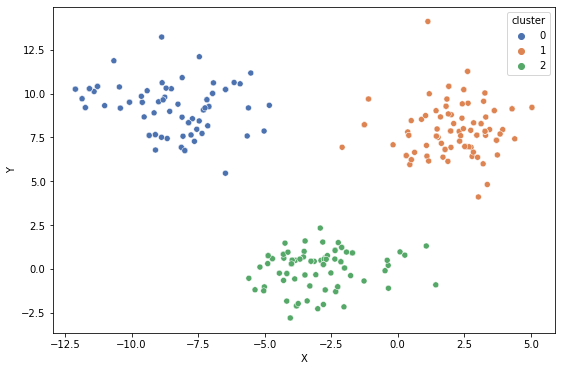

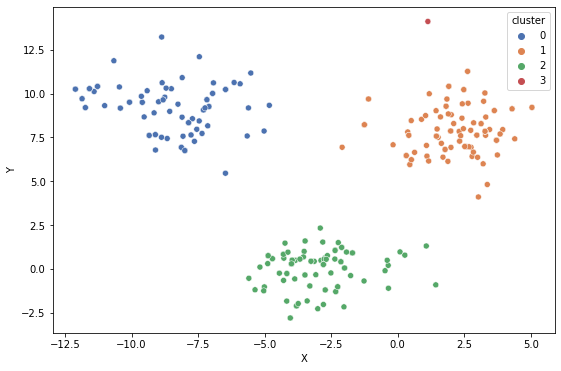

In [70]:
run_for_ds(Paths.clusters3, 1, [2, 3, 4])

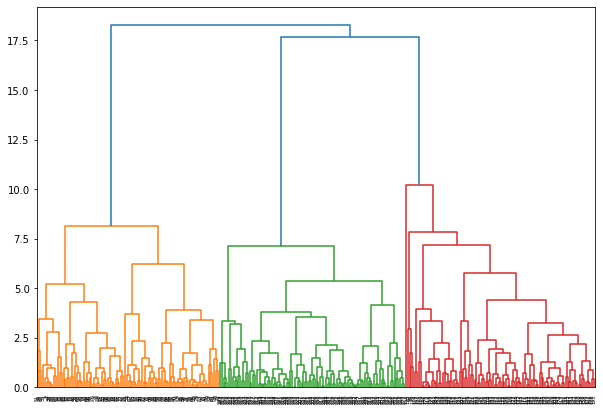

In [320]:
linked = linkage(data, LINKAGE)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()